In [2]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [3]:
train_dir=r'C:\Users\owner\Desktop\CATDOG\train'
test_dir=r'C:\Users\owner\Desktop\CATDOG\test'
img_size =25
LR = 1e-3

Model_Name = 'dogcat-{}-{},model'.format(LR,'2conv-Basic')

In [4]:
def lable_img(img):
    word_lable = img.split('.')[-3]
    if word_lable == 'cat':return[1,0]
    elif word_lable == 'dog':return[0,1]

In [5]:
def create_train_data():
    train_data=[]
    for img in tqdm(os.listdir(train_dir)):
        lable = lable_img(img)
        path = os.path.join(train_dir,img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(img_size, img_size))
        train_data.append([np.array(img),np.array(lable)])
    shuffle(train_data) 
    np.save('train_data.npy',train_data)
    return train_data

In [6]:
def process_test_data():
    test_data=[]
    for img in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(img_size,img_size))
        test_data.append([np.array(img),img_num])
        
    np.save('test_data.npy', test_data)
    return test_data
    

In [7]:
train_data = create_train_data()

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [05:40<00:00, 73.41it/s]


In [8]:
!pip install tflearn

In [9]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()


convnet = input_data(shape=[None, img_size, img_size, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
if os.path.exists('{}.meta'.format(Model_Name)):
    model.load(Model_Name)
    print('model loaded')

In [11]:
train = train_data[:-500]
test = train_data[-500:]

In [12]:
X = np.array([i[0] for i in train]).reshape(-1, img_size, img_size,1)
Y = [i[1] for i in train]

test_X = np.array([i[0] for i in test]).reshape(-1, img_size, img_size,1)
test_Y = [i[1] for i in test]

In [13]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_X}, {'targets': test_Y}), 
    snapshot_step=500, show_metric=True, run_id=Model_Name)

Training Step: 1914  | total loss: 0.54656 | time: 45.963s
| Adam | epoch: 005 | loss: 0.54656 - acc: 0.7244 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.54814 | time: 47.084s
| Adam | epoch: 005 | loss: 0.54814 - acc: 0.7254 | val_loss: 0.56849 - val_acc: 0.7080 -- iter: 24500/24500
--


In [16]:
model.save(Model_Name)

INFO:tensorflow:C:\Users\owner\Desktop\dogcat-0.001-2conv-Basic,model is not in all_model_checkpoint_paths. Manually adding it.


In [17]:
import matplotlib.pyplot as plt

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:31<00:00, 394.95it/s]


<Figure size 432x288 with 0 Axes>

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:32<00:00, 382.87it/s]


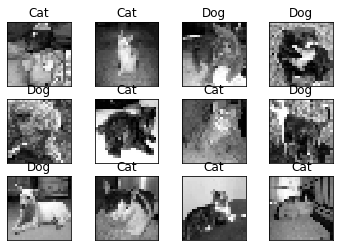

In [27]:
test_data = process_test_data()
fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(img_size, img_size, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out)==1: str_label ='Dog'
    else: str_label ='Cat'
        
    y.imshow(orig, cmap ='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [25]:
%matplotlib inline

In [28]:
with open('submission-file.csv','w') as f:
    f.write('id,label\n')
    

In [29]:
with open('submission-file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig =img_data
        data =img_data.reshape(img_size, img_size, 1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:20<00:00, 596.00it/s]
